In [22]:
# Unet

(256, 256, 2)
(256, 256, 2)
(256, 256, 2)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tamanho= 3


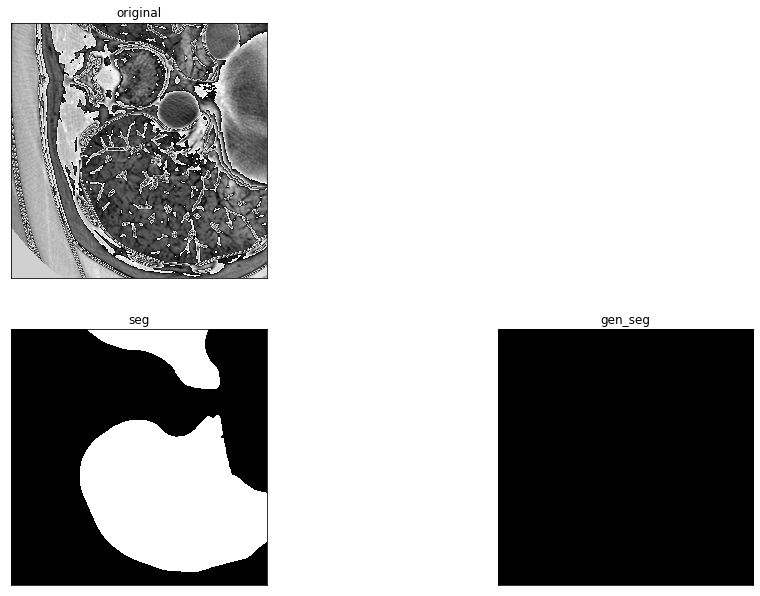

In [10]:

from sr.gerador import Gerador_UNet, FCN32
from sr.grad_cam import GradCAM
from sr.utils import input_nib_l, input_nib_v, one_hot, slice_lung, resolve_single, weights_file, random_crop, plot_sample, one_hot_lung
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import seaborn as sns

# generate a list that contains one color for each class
colors = sns.color_palette(None, 2)

def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(2):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img

# print("generator", generator.layers[0].name)

def resolve_and_plot(paciente, slice):
    unet_use = True
    cam = False 
    if unet_use:
        unet = Gerador_UNet()
        log_dir = 'logs/graph/'
        graph = tf.summary.create_file_writer(log_dir)

        generator = unet.generator_modify() #_modify
        # generator.load_weights(weights_file(None, 'pre_generator.h5'))
        # generator.load_weights("C:\\Users\\emn3\\Documents\\workspace\\seg\\denoise_ct\\weights\\srgan\\pre_generator.h5")
#         generator.load_weights("/home/work/dataset/weights/gen_bce_60/unet_pre_generator.h5")        
        generator.load_weights("/home/work/dataset/weights/srgan/unet_pre_generator.h5")


        # print(generator.last)
    else:
        generator = FCN32(2)
        generator(tf.zeros((1,224,224,3)))
        generator.summary()
        generator.load_weights('/home/work/dataset/weights/srgan/fcn32_pre_generator.h5')
    
    
    """
        0: Background (None of the following organs)
        1: Liver (figado)
        2: Bladder (bexiga)
        3: Lungs (pulmao)
        4: Kidneys (rins)
        5: Bone (osso)
        6: Brain (cerebro)
        # amarelo = 1 e roxo = 0
    """
    
    dir_input = f"OrganSegmentations//volume-{paciente}.nii.gz"
    dir_label = f"OrganSegmentations//labels-{paciente}.nii.gz"

    entrada, seg = input_nib_v(dir_input, slice), input_nib_l(dir_label, slice)
    entrada, seg = random_crop(entrada, seg, 256)
    
    entrada = tf.expand_dims(entrada, 2)
    if not unet_use:
        entrada = tf.concat([entrada, entrada, entrada], 2)
    
    seg = slice_lung(seg)
    seg = one_hot_lung(seg)

    # entrada = tf.clip_by_value(entrada, 0., 1.)

    # tf.summary.trace_on(graph=True) # , profiler=True
    
    # graph
    # exit()
    # with graph.as_default():    
    #     with tf.device("/device:cpu:0"):    
    gen_seg = resolve_single(generator, entrada)
    # show_heatmap = False
    print(gen_seg.shape)        
    print(seg.shape)
    i = np.argmax(gen_seg[0])
    icam = GradCAM(generator, i)  # , "model"# , "concatenate_3"
    if cam:
       

        heatmap = icam.compute_heatmap(entrada)

        (heatmap, output) = icam.overlay_heatmap(heatmap, entrada, alpha=0.4)
    # print(heatmap.shape)
    print(seg.shape)    
    print(gen_seg[127,127])  


    # print(gen_seg.shape)
    def show_img(gen_seg):
        img = tf.math.argmax(gen_seg,axis=2)
        img = icam.array_img(img.numpy())
#         img = give_color_to_annotation(img)
        return img
#     g_s = show_img(gen_seg.numpy()) 
#     print(g_s[127,127])

#     lista = list(map(lambda num: (icam.array_img(seg[:,:, num].numpy()), f"seg_{num+1}", 2*(num + 1) + 3) , range(seg.shape[-1])))
#     lista = lista + list(map(lambda num: (icam.array_img(gen_seg[:,:, num].numpy()), f"gen_seg_{num+1}", 2*(num + 1) + 4) , range(seg.shape[-1])))
    lista = [(show_img(seg),"seg",  3)]    
    lista = lista + [(show_img(gen_seg),"gen_seg",  4)]
    lista = [(entrada.numpy()*255 if entrada.shape[-1] == 3 else icam.array_img(entrada.numpy()), "original", 1)] + lista 
    if cam:
        lista = [(heatmap, "heatmap", 2)] + lista
        lista = [(output, "output", 3)] + lista
    plot_sample(lista)
with tf.device("/CPU:0"):
    resolve_and_plot(0, 73)

In [ ]:
# FCN32

Model: "fc_n32_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    [(None, None, None, 64),  20024384  
_________________________________________________________________
conv2d_transpose_79 (Conv2DT multiple                  1048576   
_________________________________________________________________
conv2d_317 (Conv2D)          multiple                  258       
Total params: 21,073,218
Trainable params: 21,073,218
Non-trainable params: 0
_________________________________________________________________
(256, 256, 2)
(256, 256, 2)
(256, 256, 2)
tamanho= 3


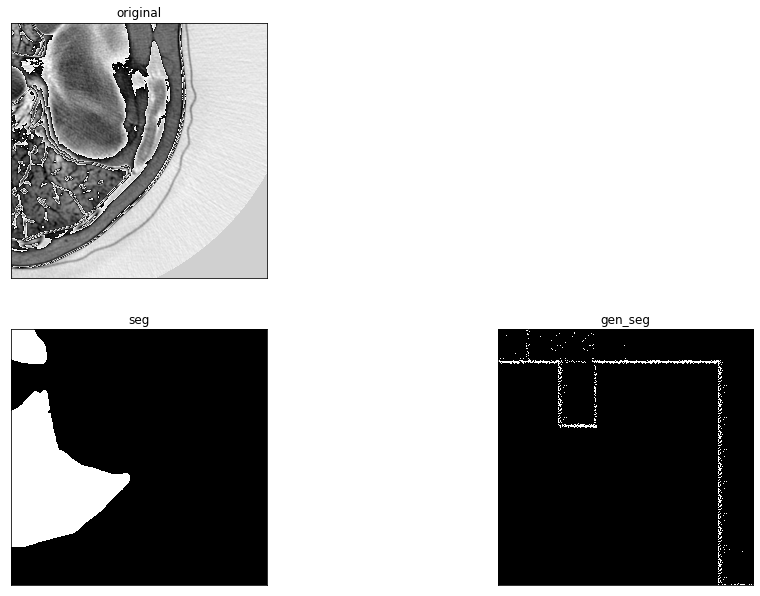

In [29]:

from sr.gerador import Gerador_UNet, FCN32
from sr.grad_cam import GradCAM
from sr.utils import input_nib_l, input_nib_v, one_hot, slice_lung, resolve_single, weights_file, random_crop, plot_sample, one_hot_lung
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np


    

def resolve_and_plot(paciente, slice):
    unet_use = False
    cam = False 
    if unet_use:
        unet = Gerador_UNet()
        log_dir = 'logs/graph/'
        graph = tf.summary.create_file_writer(log_dir)

        generator = unet.generator_modify() #_modify
        # generator.load_weights(weights_file(None, 'pre_generator.h5'))
        # generator.load_weights("C:\\Users\\emn3\\Documents\\workspace\\seg\\denoise_ct\\weights\\srgan\\pre_generator.h5")
        generator.load_weights("/home/work/dataset/weights/srgan/unet_pre_generator.h5")

        # print(generator.last)
    else:
        generator = FCN32(2)
        generator(tf.zeros((1,224,224,3)))
        generator.summary()
        generator.load_weights('/home/work/dataset/weights/srgan/fcn32_pre_generator.h5')

    """
        0: Background (None of the following organs)
        1: Liver (figado)
        2: Bladder (bexiga)
        3: Lungs (pulmao)
        4: Kidneys (rins)
        5: Bone (osso)
        6: Brain (cerebro)
        # amarelo = 1 e roxo = 0
    """
    
    dir_input = f"OrganSegmentations//volume-{paciente}.nii.gz"
    dir_label = f"OrganSegmentations//labels-{paciente}.nii.gz"

    entrada, seg = input_nib_v(dir_input, slice), input_nib_l(dir_label, slice)
    entrada, seg = random_crop(entrada, seg, 256)
    
    entrada = tf.expand_dims(entrada, 2)
    if not unet_use:
        entrada = tf.concat([entrada, entrada, entrada], 2)
    
    seg = slice_lung(seg)
    seg = one_hot_lung(seg)

    # entrada = tf.clip_by_value(entrada, 0., 1.)

    # tf.summary.trace_on(graph=True) # , profiler=True
    
    # graph
    # exit()
    # with graph.as_default():    
    #     with tf.device("/device:cpu:0"):    
    gen_seg = resolve_single(generator, entrada)
    # show_heatmap = False
    print(gen_seg.shape)        
    print(seg.shape)

    i = np.argmax(gen_seg[0])
    icam = GradCAM(generator, i)  # , "model"# , "concatenate_3"
    if cam:

        heatmap = icam.compute_heatmap(entrada)

        (heatmap, output) = icam.overlay_heatmap(heatmap, entrada, alpha=0.4)
    # print(heatmap.shape)
    print(seg.shape)
    # print(gen_seg.shape)
    def show_img(gen_seg):
        img = tf.math.argmax(gen_seg,axis=2)
        img = icam.array_img(img.numpy())
        return img
        
    
#     lista = list(map(lambda num: (icam.array_img(seg[:,:, num].numpy()), f"seg_{num+1}", 2*(num + 1) + 3) , range(seg.shape[-1])))
#     lista = lista + list(map(lambda num: (icam.array_img(gen_seg[:,:, num].numpy()), f"gen_seg_{num+1}", 2*(num + 1) + 4) , range(seg.shape[-1])))
#     lista = lista + list(map(lambda num: (icam.array_img(gen_seg[:,:, num].numpy()), f"gen_seg_{num+1}", 2*(num + 1) + 4) , range(seg.shape[-1])))
    lista = [(show_img(seg),"seg",  3)]    
    lista = lista + [(show_img(gen_seg),"gen_seg",  4)]

    lista = [((entrada.numpy()*255).astype("uint8") if entrada.shape[-1] == 3 else icam.array_img(entrada.numpy()), "original", 1)] + lista 
    
#     print([i.shape for i in lista])
    if cam:
        lista = [(heatmap, "heatmap", 2)] + lista
        lista = [(output, "output", 3)] + lista
    plot_sample(lista)
    
with tf.device("/CPU:0"):
    resolve_and_plot(0, 73)

In [7]:
!tensorboard --port 35781  --logdir logs/gradient_tape  --bind_all

2022-11-03 14:13:46.149128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.3.0+nv at http://main1:35781/ (Press CTRL+C to quit)
^C


In [18]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs/gradient_tape (started 0:00:11 ago; pid 110306)


In [19]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs/gradient_tape (started 0:00:20 ago; port 6006, pid 110306).
